In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install umap-learn[plot]
!pip install gensim

In [ ]:
from statistics import linear_regression
from sklearn import svm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelBinarizer


from sklearn.pipeline import Pipeline
import nltk
import umap
from nltk.help import upenn_tagset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, precision_score, average_precision_score
import pandas as pd
import numpy as np
import time
import os
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import auc
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import wordnet,subjectivity,stopwords
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import re
import string
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

nltk.download("subjectivity")
nltk.download('tagsets_json')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_ta

True

In [ ]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

print(subjectivity.categories())
# print(subjectivity.sents(categories="subj"))
subjective_sentences = subjectivity.sents(categories="subj")
objective_sentences = subjectivity.sents(categories="obj")

data_with_labels = []
assert(len(subjective_sentences) == len(objective_sentences))
for i in range(len(subjective_sentences)):
    obj_sentence = objective_sentences[i]
    subj_sentence = subjective_sentences[i]
    data_with_labels.append({"label":"obj","sentence":obj_sentence})
    data_with_labels.append({"label":"subj","sentence":subj_sentence})

# print(upenn_tagset()) -> Μέρη του λόγου σε προτάσεις και σε τι κλήση κλπ βρίσκονται
lemmatizer = WordNetLemmatizer()
tagger = PerceptronTagger()
docs = []
labels = []
for doc in tqdm(data_with_labels):
    sentence = " ".join(doc["sentence"])
    label = doc["label"]
    document = re.sub(r'\W', ' ', str(sentence))

    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    document = re.sub(r'\s+', ' ', document, flags=re.I)

    document = document.lower()

    document = document.split()

    doc_pos = [x[1] for x in tagger.tag(document)]

    document = \
        [lemmatizer.lemmatize(token, pos=nltk_pos_tagger(pos_tag)) \
             if nltk_pos_tagger(pos_tag) != None else lemmatizer.lemmatize(token) \
         for token, pos_tag in zip(document, doc_pos)]

    document = ' '.join(document)

    docs.append(document)
    value_of_label = 0 if label == "subj" else 1
    labels.append(value_of_label)
    # labels.append(label)
# print(docs)
print(len(subjective_sentences),len(objective_sentences))


['obj', 'subj']


100%|██████████| 10000/10000 [00:21<00:00, 455.11it/s]

5000 5000


In [ ]:
batch = 256


In [ ]:
X_train_val,X_test,y_train_val,y_test = train_test_split(docs, labels, test_size=0.3, random_state=1924)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size=0.2,random_state=1924)

print('Train samples: {}'.format(len(X_train)))
print('Val samples: {}'.format(len(X_val)))
print('Test samples: {}'.format(len(X_test)))

Train samples: 5600
Val samples: 1400
Test samples: 3000


In [ ]:
stop_words = set(stopwords.words("english"))
def tokenize_samples(samples):
    tokenized_samples = []
    for sample in samples:
        tokens = []
        # Split text into sentences
        sentences = sent_tokenize(sample)
        for sent in sentences:
            # Tokenize each sentence into words
            words = word_tokenize(sent)
            for word in words:
                # Filter out stopwords and unwanted tokens
                if '\n' in word or "\t" in word or "--" in word or "*" in word or word.lower() in stop_words:
                    continue
                if word.strip():
                    # Process the token and add to list
                    tokens.append(word.replace('"', "'").strip().lower())
        tokenized_samples.append(tokens)

    return tokenized_samples
X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)

In [ ]:
for item in X_train_tokenized[:2]:
  print(item, '\n')

['infuriate', 'full', 'frontal', 'close', 'real', 'life', 'make', 'sense', 'invigorate', 'give', 'damn'] 

['romy', 'dispense', 'order', 'like', 'drill', 'sergeant', 'scramble', 'southwest', 'round', 'last', 'two', 'survive', 'member', 'eagle', 'wwii', '17', 'bomber', 'crew'] 



In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000, sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)

(5600, 5000)
(1400, 5000)
(3000, 5000)


In [ ]:
svd = TruncatedSVD(n_components=300, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print(X_train_svd.shape)
print(X_val_svd.shape)
print(X_test_svd.shape)

(5600, 300)
(1400, 300)
(3000, 300)


In [ ]:
lb = LabelBinarizer()
target_list = ["obj","subj"]

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_val_1_hot = lb.transform([target_list[x] for x in y_val])
y_test_1_hot = lb.transform([target_list[x] for x in y_test])
print(y_train[:5])
print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))

[0, 1, 1, 0, 0]
y_train_1_hot[0]: [0]


# Logistic Regression (Baseline Model)


In [ ]:

clf = LogisticRegression(solver="sag", random_state = 42)
clf.fit(X_train_svd, y_train)

predictions = clf.predict(X_val_svd)
print(classification_report(y_val, predictions, target_names=["subj","obj"]))

              precision    recall  f1-score   support

        subj       0.89      0.82      0.86       708
         obj       0.83      0.90      0.87       692

    accuracy                           0.86      1400
   macro avg       0.86      0.86      0.86      1400
weighted avg       0.86      0.86      0.86      1400



In [ ]:
# from sklearn.metrics import accuracy_score
predictions = clf.predict(X_val_svd)
print(f'Logistic Regression Validation Accuracy: {accuracy_score(y_val, predictions)*100:.2f}%')

predictions = clf.predict(X_test_svd)
print(f'Logistic Regression Test Accuracy:{accuracy_score(y_test, predictions)*100:.2f}%')

Logistic Regression Validation Accuracy: 86.21%
Logistic Regression Test Accuracy:86.40%


In [ ]:
import torch # torch provides basic functions, from setting a random seed (for reproducability) to creating tensors.
import torch.nn as nn # torch.nn allows us to create a neural network.
import torch.nn.functional as F # nn.functional give us access to the activation and loss functions.
from torch.optim import Adam # optim contains many optimizers. Here, we're using SGD, stochastic gradient descent, specifically Adam.

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# MLP (Multi-Layer Perceptron)

In [ ]:
class MLP_tf_idf(nn.Module):

    def __init__(self,first_layer_size,second_layer_size,dropout_ratio):
      # You can pass more arguments in __init__ like the shapes of the hidden layers or dropout probability. I have not done that here since this serves
                        # as an elementary example. Then, everytime you call the model class you have to set a value to these hyperparameters. This can help a lot when you're
                        # trying to tune your hyperparameters. Please check the pytorch documentation for more.
        super(MLP_tf_idf, self).__init__()
        # an affine operation: y = Wx + b
        self.dense1 = nn.Linear(300, first_layer_size)  # 500 from the dimensions of the tensor inputs. In this case, each item will be a vector of 500 SVD values
        self.dense2 = nn.Linear(first_layer_size,second_layer_size)
        self.dense3 = nn.Linear(second_layer_size, 2) # 20 classes so we need a final layer of shape (20,)
        self.dropout = nn.Dropout(dropout_ratio)
        # If you want to do different dropout probabilities at different layers you can do self.dropout1 = nn.Dropout(0.2), self.dropout2 = nn.Dropout(0.3) etc.

    def forward(self, input):
        # Dense layer 1. Takes the vector of shape 500 and maps it to 512 nodes.
        # Input shape: (batch_size, 500)
        d1 = F.relu(self.dense1(input)) # (batch_size, 512)
        # Apply 50% dropout
        drop1 = self.dropout(d1) # (batch_size, 512)
        # Dense layer 2. Takes the 512 nodes and connects them to 256 nodes
        d2 = F.relu(self.dense2(drop1)) # (batch_size, 256)
        # Apply 50% dropout
        drop2 = self.dropout(d2) # (batch_size, 256)
        # Connect the layer of 256 nodes to the final layer of 20 nodes (one per news category)
        #output = F.softmax(self.dense3(drop2), dim = 1) # (batch_size, 20)
        logits = self.dense3(drop2) # (batch_size, 20)
        #return output
        return logits # Careful! Pytorch' CrossEntropyLoss expects un-softmaxed logits.



mlp_classifier = MLP_tf_idf(256,256,0.5)
print(mlp_classifier)

# Count the total number of parameters
total_params = sum(p.numel() for p in mlp_classifier.parameters())
print(f"MLP TF-IDF Total number of parameters: {total_params}")

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in mlp_classifier.parameters() if p.requires_grad)
print(f"MLP TF-IDF Number of trainable parameters: {trainable_params}")

MLP_tf_idf(
  (dense1): Linear(in_features=300, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (dense3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
MLP TF-IDF Total number of parameters: 143362
MLP TF-IDF Number of trainable parameters: 143362


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_svd, dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train_1_hot, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_svd, dtype=torch.float32)
#y_val_tensor = torch.tensor(y_val_1_hot, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_svd, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test_1_hot, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print("Batch size is: ",batch_size)

Batch size is:  256


In [ ]:
def train_mlp_with_params(first_layer_size,second_layer_size,dropout_prob):
    global train_loader,val_loader,test_loader
    print(f"Running MLP TF-IDF training {first_layer_size},{second_layer_size},{dropout_prob}")
    model_mlp_tf_idf = MLP_tf_idf(first_layer_size,second_layer_size,dropout_prob) # Instantiate the model. If your model had variable arguments, you would have to set their value here
    model_mlp_tf_idf.to(device)
    optimizer = Adam(model_mlp_tf_idf.parameters(), lr = 0.001) # Define the optimizer you wish to use, in this case Adam
    criterion = nn.CrossEntropyLoss() # Define the loss function specific to your problem.
                                  # Check pytorch documentation for more details. Different loss functions are used for different problems
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], 'train_f1_score': [], 'val_f1_score': []}
    epochs = 150
## 250 epochs are too much in our scenario, the loss gets too low
## 150 seems good for us
## this is the optimization loop. Each time the optimizer sees all of the training data is called an "epoch".

    best_val_loss = float("inf") # Initialize to a high value to track the lowest validation loss
    best_model_path = None  # To keep track of the previous best model file


    for epoch in range(epochs):
        model_mlp_tf_idf.train()  # Set the model to training mode
        running_loss = 0.0  # Track the loss for the epoch
        train_outputs = [] # the list which contains the outputs of a batch
        train_labels = [] # the list which contains the labels of a batch

    ## this internal loop is where the optimizer sees all of the training data and where we
    ## calculate the total_loss for all of the training data.
        for batch in train_loader:

            features, labels = batch
            features = features.to(device) # Move features to device
            labels = labels.to(device) # Move labels to device

            optimizer.zero_grad()  # Zero the gradients

        # Forward pass: Computes the model output
            outputs = model_mlp_tf_idf(features)

        # Calculate the loss with class indices (not one-hot)
            loss = criterion(outputs, labels)  # labels should be class indices, not one-hot
            loss.backward()  # Backward pass

            optimizer.step()  # Optimize (Update the model parameters)

        # Accumulate the loss
            running_loss += loss.item()

        # the outputs from forward pass
            train_outputs.append(outputs)
            train_labels.append(labels)

        #----------------------------------------------------------------------------------------------------------------

    # Concatenate all outputs and labels
        train_outputs = torch.cat(train_outputs)
        train_labels = torch.cat(train_labels)

    # (1) Get label indices
    ####################################################
    #train_classes = torch.argmax(train_labels, dim = 1)
    ####################################################
        train_classes = train_labels

    # (2) Get predicted class indices (we want ro transform the vector to one-hot
    #     (we put one in the index of max element and zeros to others))
        train_predicted_classes = torch.argmax(train_outputs, dim=1)

    # Print average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        # print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {epoch_loss:.4f}')

    #mexri 0.003 kati

        train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(train_classes.cpu(), train_predicted_classes.cpu())
        train_f1_score = f1_score(train_classes.cpu(), train_predicted_classes.cpu(), average='weighted')
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_f1_score'].append(train_f1_score)

    ############################################################################

    # Validation phase
    # Set the model to evaluation mode
        model_mlp_tf_idf.eval()
        val_running_loss = 0.0
        all_outputs = []
        all_labels = []

    # We want to not update the gradients when it is updating the weights
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)
                outputs = model_mlp_tf_idf(features)
            # We compute the validation loss
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                all_outputs.append(outputs)
                all_labels.append(labels)

        # Concatenate all outputs and labels
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        # Get label indices
        #true_classes = torch.argmax(all_labels, dim=1)
        true_classes = all_labels

        # Get predicted class indices
        predicted_classes = torch.argmax(all_outputs, dim=1)

        # Calculate metrics on the entire validation set
        val_accuracy = accuracy_score(true_classes.cpu(), predicted_classes.cpu())
        val_f1 = f1_score(true_classes.cpu(), predicted_classes.cpu(), average='weighted')

        # Append to history
        val_loss = val_running_loss / len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1_score'].append(val_f1)

        # Print validation metrics
        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        # Save checkpoint at the lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'

            # Delete the previous best model if it exists
            if best_model_path is not None:
                os.remove(best_model_path)

            # Save the new best model
            torch.save(model_mlp_tf_idf.state_dict(), new_model_path)
            best_model_path = new_model_path  # Update the best model path
            #print(f"Checkpoint saved at epoch {epoch+1} with F1: {val_f1:.4f}")
    return model_mlp_tf_idf,history,best_model_path

In [ ]:
list_hyper_parameters = []
list_hyper_parameters.append((512,128,0.4))
list_hyper_parameters.append((256,64,0.3))
results = []
for var_element in list_hyper_parameters:
    model_mlp_tf_idf,history,best_model_path = train_mlp_with_params(var_element[0], var_element[1], var_element[2])
    results.append((model_mlp_tf_idf,history,best_model_path))

Running MLP TF-IDF training 512,128,0.4
Validation Loss: 0.6727198163668314
Validation Accuracy: 0.6479, F1 Score: 0.6014
Validation Loss: 0.5191143949826559
Validation Accuracy: 0.7886, F1 Score: 0.7829
Validation Loss: 0.3438200255235036
Validation Accuracy: 0.8593, F1 Score: 0.8591
Validation Loss: 0.311693807442983
Validation Accuracy: 0.8664, F1 Score: 0.8664
Validation Loss: 0.3020752469698588
Validation Accuracy: 0.8721, F1 Score: 0.8721
Validation Loss: 0.3062398781379064
Validation Accuracy: 0.8657, F1 Score: 0.8656
Validation Loss: 0.30017367005348206
Validation Accuracy: 0.8679, F1 Score: 0.8679
Validation Loss: 0.30025113622347516
Validation Accuracy: 0.8693, F1 Score: 0.8693
Validation Loss: 0.30786730349063873
Validation Accuracy: 0.8671, F1 Score: 0.8671
Validation Loss: 0.30815114080905914
Validation Accuracy: 0.8693, F1 Score: 0.8693
Validation Loss: 0.3133202791213989
Validation Accuracy: 0.8657, F1 Score: 0.8655
Validation Loss: 0.30795777837435406
Validation Accurac

In [ ]:
for model_mlp_tf_idf,history,best_model_path in results:
    model_mlp_tf_idf.eval()
    model_mlp_tf_idf.to("cpu")

    pred_val = model_mlp_tf_idf(X_val_tensor)

    y_pred_val = torch.argmax(pred_val, dim=1)
    print(model_mlp_tf_idf)
    print(f"Results in Validation Data for MLP with TFIDF Features, trained for 150 epochs")
    print(classification_report(y_val, y_pred_val, target_names=["subj","obj"]))

    print(f'MLP TF-IDF Validation Accuracy: {accuracy_score(y_val, y_pred_val)*100:.2f}%')

    predictions_test = model_mlp_tf_idf(X_test_tensor)
    y_pred_test = torch.argmax(predictions_test, dim=1)
    print(f'MLP TF-IDF Test Accuracy:{accuracy_score(y_test, y_pred_test)*100:.2f}%')

MLP_tf_idf(
  (dense1): Linear(in_features=300, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
Results in Validation Data for MLP with TFIDF Features, trained for 150 epochs
              precision    recall  f1-score   support

        subj       0.84      0.86      0.85       708
         obj       0.85      0.83      0.84       692

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400

MLP TF-IDF Validation Accuracy: 84.71%
MLP TF-IDF Test Accuracy:85.53%
MLP_tf_idf(
  (dense1): Linear(in_features=300, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=64, bias=True)
  (dense3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Results in Validation Dat

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plotting loss
    plt.figure()
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting accuracy
    plt.figure()
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plotting F1 score
    plt.figure()
    plt.plot(history['train_f1_score'], label='Training F1 Score')
    plt.plot(history['val_f1_score'], label='Validation F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [ ]:
def plot_training_histories(histories):
    # Plotting loss
    colors = [("lightgreen","green"),("lightblue","blue")]
    plt.figure()
    for (index,history) in enumerate(histories):
      plt.plot(history['train_loss'], label=f'Training Loss {index}',color=colors[index][0])
      plt.plot(history['val_loss'], label=f'Validation Loss {index}',color=colors[index][1])

    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    for (index,history) in enumerate(histories):
        plt.plot(history['train_accuracy'], label=f'Training Accuracy {index}',color=colors[index][0])
        plt.plot(history['val_accuracy'], label=f'Validation Accuracy {index}',color=colors[index][1])
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    for (index,history) in enumerate(histories):
        plt.plot(history['train_f1_score'], label=f'Training Accuracy {index}',color=colors[index][0])
        plt.plot(history['val_f1_score'], label=f'Validation Accuracy {index}',color=colors[index][1])
    plt.title('F1 Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()


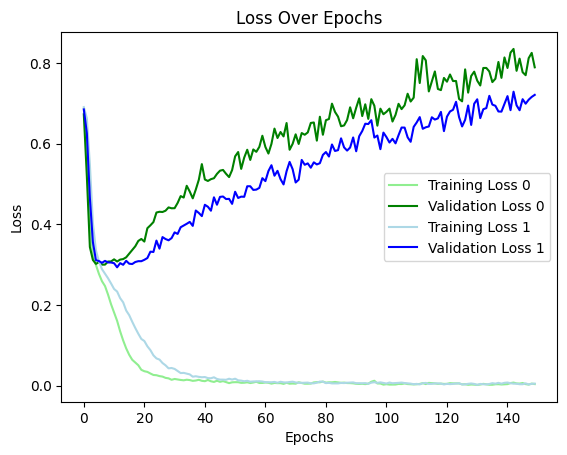

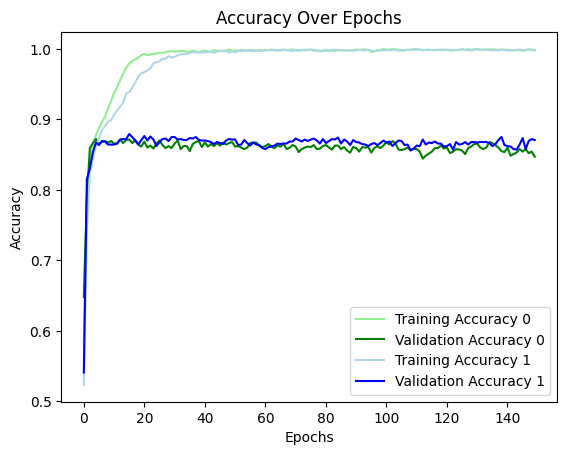

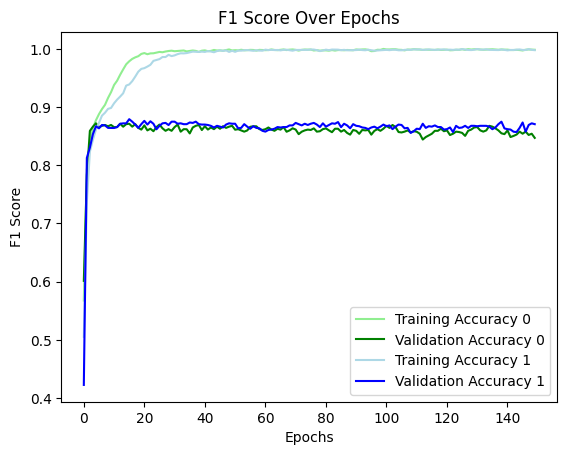

In [ ]:
histories = list(map(lambda x: x[1],results))
plot_training_histories(histories)

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
STOP_WORDS = set(stopwords.words('english'))

def text_centroid(text, model):
    """ Calculate centroid function """
    text_vec =[]
    counter = 0
    for word in text:
        if word in STOP_WORDS:
          continue
        try:
            if counter == 0:
                text_vec = model[word.lower()]
            else:
                text_vec = np.add(text_vec, model[word.lower()])
            counter+=1
        except:
            pass

    return np.asarray(text_vec) / counter

In [ ]:
# Calculate centroids for train, val and test documents

X_train_centroids = [text_centroid(sent, wv) for sent in X_train_tokenized]
X_train_centroids = np.stack(X_train_centroids, axis=0)

X_val_centroids = [text_centroid(sent, wv) for sent in X_val_tokenized]
X_val_centroids = np.stack(X_val_centroids, axis=0)

X_test_centroids = [text_centroid(sent, wv) for sent in X_test_tokenized]
X_test_centroids = np.stack(X_test_centroids, axis=0)

print(X_train_centroids.shape)

(5600, 300)


In [ ]:
class MLP_centroids(nn.Module):
    def __init__(self):
        super(MLP_centroids, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(300, 1024), # Dense layer. Takes the input of shape (batch_size, 300) and connects it to 1024 nodes (batch_size, 1024)
            nn.ReLU(), # Applies ReLU activation function
            nn.Dropout(0.3), # Applies 30% dropout
            nn.Linear(1024, 1024), # Dense layer. Connects the 1024 nodes with 1024 nodes. (batch_size, 1024)
            nn.ReLU(), # Applies ReLU activation function
            nn.Dropout(0.3), # Applies 30% dropout
            nn.Linear(1024, 512), # Dense layer. Takes the 1024 nodes and connects them to 512. (batch_size, 512)
            nn.ReLU(), # Applies ReLU activation function
            nn.Dropout(0.3), # Applies 30% Dropout
            nn.Linear(512, 20) # Final dense layer. Produces the so called "logits" which are the results after the dense layer before the softmax.
        )

    def forward(self, input):
        return self.network(input) # Forward pass of the input through the neural network

mlp_cent = MLP_centroids()
print(mlp_cent)

NameError: name 'nn' is not defined

In [ ]:
X_train_cent_tensor = torch.tensor(X_train_centroids, dtype=torch.float32)
X_val_cent_tensor = torch.tensor(X_val_centroids, dtype=torch.float32)
X_test_cent_tensor = torch.tensor(X_test_centroids, dtype=torch.float32)

In [ ]:
batch_size = 256

train_dataset_cent = TensorDataset(X_train_cent_tensor, y_train_tensor)
train_loader_cent = DataLoader(train_dataset_cent, batch_size=batch_size, shuffle=True)

val_dataset_cent = TensorDataset(X_val_cent_tensor, y_val_tensor)
val_loader_cent = DataLoader(val_dataset_cent, batch_size=batch_size, shuffle=True)

test_dataset_cent = TensorDataset(X_test_cent_tensor, y_test_tensor)
test_loader_cent = DataLoader(test_dataset_cent, batch_size=batch_size, shuffle=True)

In [ ]:
## create the neural network we want to train.
model_mlp_centroids = MLP_centroids()
model_mlp_centroids.to(device)

optimizer = Adam(model_mlp_centroids.parameters(), lr = 0.001) ## here we're creating an optimizer to train the neural network.
                                            ## NOTE: There are a bunch of different ways to optimize a neural network.
                                            ## In this example, we'll use Adam. .

criterion = nn.CrossEntropyLoss() # This applies a transformation called log-softmax (softmax first, then logarithm) in order to get the cross entropy loss.
                                  # This is why we need the model to return the logits

epochs=250
##250 are too many, it reaches around 0.00X loss
##It reaches early the 0.00X loss and then jumps around
## this is the optimization loop. Each time the optimizer sees all of the training data is called an "epoch".
for epoch in range(epochs):
    model_mlp_centroids.train()  # Set the model to training mode
    running_loss = 0.0

    ## this internal loop is where the optimizer sees all of the training data and where we
    ## calculate the total_loss for all of the training data.
    for batch in train_loader_cent:

        features, labels = batch

        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model_mlp_centroids(features)

        # Calculate the loss with class indices (not one-hot)
        loss = criterion(outputs, labels)  # labels should be class indices, not one-hot
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss / len(train_loader)}")

print("Training complete!")

Epoch 1/250, Training Loss: 1.164127450097691
Epoch 2/250, Training Loss: 0.37083037062124774
Epoch 3/250, Training Loss: 0.2936626821756363
Epoch 4/250, Training Loss: 0.2710951119661331
Epoch 5/250, Training Loss: 0.25331439619714563
Epoch 6/250, Training Loss: 0.24100010977549988
Epoch 7/250, Training Loss: 0.2280728512189605
Epoch 8/250, Training Loss: 0.20884362946857105
Epoch 9/250, Training Loss: 0.19472174481912094
Epoch 10/250, Training Loss: 0.18066263097253712
Epoch 11/250, Training Loss: 0.15553505549376662
Epoch 12/250, Training Loss: 0.12251903184435585
Epoch 13/250, Training Loss: 0.10881026935848323
Epoch 14/250, Training Loss: 0.08170935155993159
Epoch 15/250, Training Loss: 0.06916083666411313
Epoch 16/250, Training Loss: 0.06285108490423723
Epoch 17/250, Training Loss: 0.046143903651020744
Epoch 18/250, Training Loss: 0.03937323416837237
Epoch 19/250, Training Loss: 0.04019607336853038
Epoch 20/250, Training Loss: 0.0399808064526455
Epoch 21/250, Training Loss: 0.030

In [ ]:
model_mlp_centroids.eval()
model_mlp_centroids.to("cpu")

pred_val = model_mlp_centroids(X_val_cent_tensor)

y_pred_val = torch.argmax(pred_val, dim=1)
print(f"For MLP with centroids trained for {epochs} epochs in validation data")
print(classification_report(y_val, y_pred_val, target_names=["subj","obj"]))

For MLP with centroids trained for 250 epochs in validation data
              precision    recall  f1-score   support

        subj       0.93      0.88      0.90       708
         obj       0.88      0.93      0.90       692

    accuracy                           0.90      1400
   macro avg       0.90      0.90      0.90      1400
weighted avg       0.90      0.90      0.90      1400



Shape:  (5600, 2)


<Axes: title={'center': 'UMAP Reduction'}>

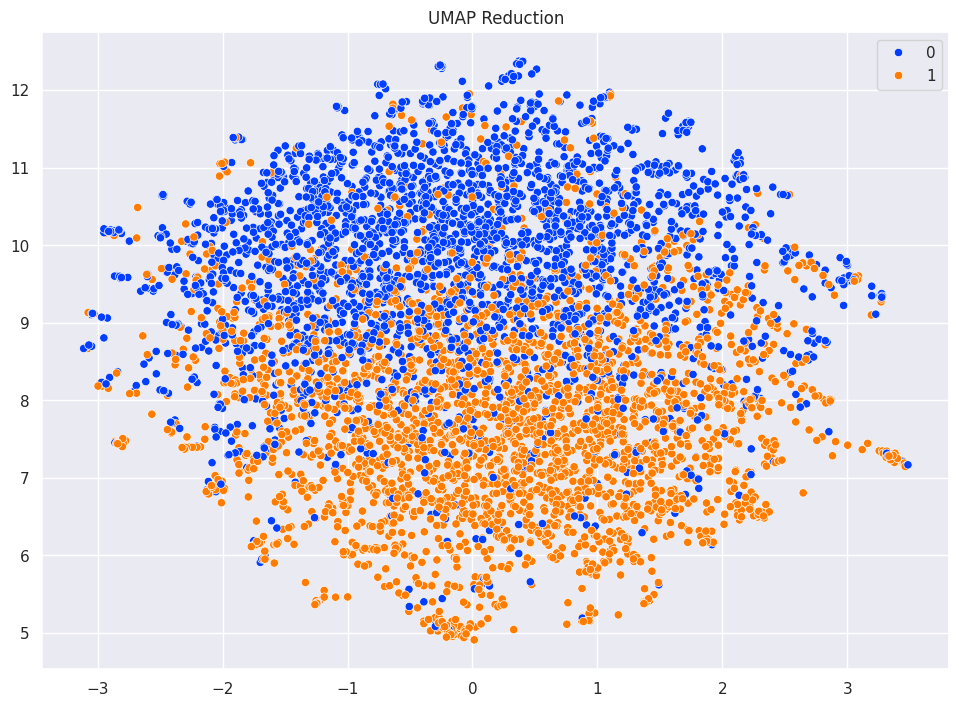

In [ ]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
reducer = umap.UMAP(n_components=2)
x_train_embedding = reducer.fit_transform(X_train_tfidf)
print('Shape: ', x_train_embedding.shape)


plt.figure()
plt.title('UMAP Reduction')
sns.scatterplot(x=x_train_embedding[:,0],
                y=x_train_embedding[:,1],
                hue=y_train,
                legend='full',
                palette=palette)

Training took: 0.002949953079223633 seconds 

Train accuracy: 51.04%
Test accuracy: 48.33% 


Confusion Matrix for test data:
Classification report for baseline
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.48      0.65      3000

    accuracy                           0.48      3000
   macro avg       0.50      0.24      0.33      3000
weighted avg       1.00      0.48      0.65      3000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


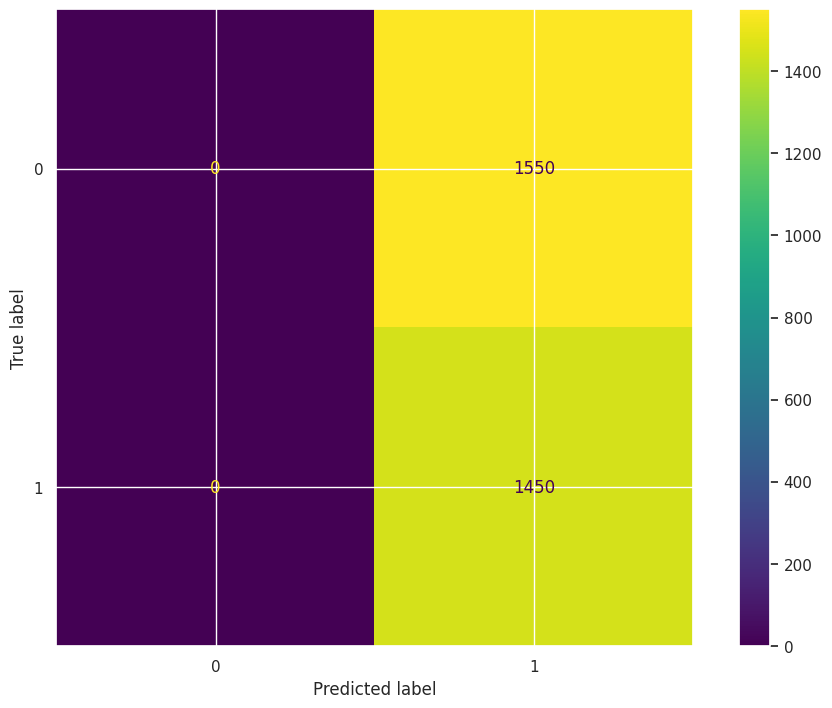

In [ ]:
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train_tfidf,y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

predictions = baseline.predict(X_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_test = baseline.predict(X_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score*100))

confusion_plot = ConfusionMatrixDisplay

confusion_plot.from_estimator(estimator=baseline,
                              X=X_test_tfidf,
                              y=y_test,
                              values_format = '.0f')
print("\nConfusion Matrix for test data:")




print("Classification report for baseline")
results = classification_report(predictions_test, y_test)
print(results)

# Deprecated

In [ ]:
sklearn_logistic_regression_classifier = LogisticRegression(solver="liblinear")
start_time = time.time()
sklearn_logistic_regression_classifier.fit(X_train_tfidf, y_train)
finish_time = time.time()
var_float_total_time = finish_time - start_time
print("Completion Time for Training: {0:.2f} seconds".format(start_time))
ndarray_predicted_category_labels_train_data = sklearn_logistic_regression_classifier.predict(X_train_tfidf)
ndarray_predicted_category_labels_test_data = sklearn_logistic_regression_classifier.predict(X_test_tfidf)
print("Predicted Train Labels Length is: ", len(ndarray_predicted_category_labels_train_data))
print("Predicted Test Labels Length is: ", len(ndarray_predicted_category_labels_test_data))
array_support_train_data = precision_recall_fscore_support(y_train, ndarray_predicted_category_labels_train_data, average = None)
array_support_test_data = precision_recall_fscore_support(y_test, ndarray_predicted_category_labels_test_data, average = None)

str_metrics_train_data = classification_report(ndarray_predicted_category_labels_train_data, y_train)
str_metrics_test_data = classification_report(ndarray_predicted_category_labels_test_data, y_test)
array_precision_scores_train_data = precision_score(y_train, ndarray_predicted_category_labels_train_data, average = None)
array_precision_scores_test_data = precision_score(y_test, ndarray_predicted_category_labels_test_data,  average = None)
array_recall_scores_train_data = recall_score(y_train, ndarray_predicted_category_labels_train_data, average = None)
array_recall_scores_test_data = recall_score(y_test, ndarray_predicted_category_labels_test_data,  average = None)
array_f1_scores_train_data = f1_score(y_train, ndarray_predicted_category_labels_train_data, average = None)
array_f1_scores_test_data = f1_score(y_test, ndarray_predicted_category_labels_test_data,  average = None)


print("====For Logistic Regression ======")

print("Support for train data is: ", array_support_train_data )
print("Precision scores for train data: ", array_precision_scores_train_data)
print("Recall scores for train data: ", array_recall_scores_train_data)
print("F1 Scores for train data: ", array_f1_scores_train_data)

print("Support for test data is: ", array_support_test_data)
# print("Precision scores for test data: ", array_precision_scores_test_data,  "\n type is", type(array_precision_scores_test_data))
print("Recall scores for test data: ", array_recall_scores_test_data)
print("F1 Scores for test data: ", array_f1_scores_test_data)
print("Metrics for training data")
print(str_metrics_train_data)
print("Metrics for testing data")
print(str_metrics_test_data)

In [ ]:
np.seterr(all='ignore')
estimators = {'Logistic Regression':sklearn_logistic_regression_classifier}
              #"Baseline":baseline}
              # 'SVM':svm.SVC(kernel='linear', probability=True)}

macro_avg_prec_recall = 0
for (name,estimator) in estimators.items():

    model = estimator
    # model.fit(x_train_tfidf,train_labels)
    # We use the probabilities because the precision_recall_curve function needs them
    pred = model.predict_proba(X_test_tfidf)
    # model.predict() returns outputs of 0 or 1
    # model.predict_proba() returns an array: [P(x=0), P(x=1)]

    precision, recall, thresholds = precision_recall_curve(y_train, pred[:,1])

    macro_avg_recall = []
    macro_avg_precision = []
    print(thresholds,type(thresholds))
    for t in thresholds:
        precisions = precision_score(y_train, pred[:,1] > t,average=None,zero_division="warn")
        recalls = recall_score(y_train,pred[:,1] > t,average=None,zero_division="warn")
        avg_precision = np.average(precisions)
        avg_recalls = np.average(recalls)
        macro_avg_precision.append(avg_precision)
        macro_avg_recall.append(avg_recalls)

    new_prec = []
    new_recall = []
    while(len(macro_avg_recall) > 0):
        current_max,current_index = max((value,index) for index,value in enumerate(macro_avg_recall))
        new_recall.append(current_max.item())
        new_prec.append(macro_avg_precision[current_index].item())
        macro_avg_recall.remove(current_max)
    print("Macro avg AUC",auc(new_recall,new_prec))

    print("Macro average recall",new_recall)
    print("Macro average precision",new_prec)
    # macro_avg_area = auc(macro_avg_recall,macro_avg_precision)
    plt.figure()
    plt.plot(new_recall,new_prec,label="Macro Average Precision Recall")
    plt.xlabel("Macro avg Recall")
    plt.ylabel("Macro avg Precision")
    plt.ylim([0.5, 0.93])
    plt.xlim([0.5, 0.93])
    plt.title(f'Precision-Recall Macro average {name}')
    plt.legend(loc="lower left")
    plt.show()

    area = auc(recall, precision)
    print("Area is: ",area)

    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
    plt.legend(loc="lower left")
    plt.show()


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

In [ ]:
test_sizes = [0.1,0.2,0.3,0.4,0.5]
for test_sz in test_sizes:
  x,y = X_train_tfidf,y_train
  title = f"Learning Curves (Logistic Regression) Test Size={test_sz}"
  cv = ShuffleSplit(n_splits=5, test_size = test_sz , random_state=1924)
  estimator = sklearn_logistic_regression_classifier
  plot_learning_curve(estimator, title, x, y, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()